# PCA Modeling

In [34]:
# import libraries and setup
import pandas as pd
import numpy as np
import plotly_express as px
import seaborn as sns
from scipy.linalg import eigh

# settings
norm_docs = False 
center_term_vectors = False

OHCO = ['book_id', 'chap_id']
output_dir = "/Users/lucyshichman/Documents/MSDS/DS5001/final_project/woolf2vec/output"

# import normalized, reduced TFIDF, LIB, VOCAB tables
TFIDF_L2 = pd.read_csv(f'{output_dir}/tfidf_l2.csv').set_index(OHCO)
LIB = pd.read_csv(f"{output_dir}/lib.csv").set_index('book_id')
VOCAB = pd.read_csv(f'{output_dir}/vocab.csv').set_index('term_str').dropna()

## PCA

In [35]:
# handle nulls-- remove bags with nulls
a = len(TFIDF_L2)
TFIDF_L2 = TFIDF_L2.dropna()
b = len(TFIDF_L2)
bag_loss = a - b

bag_loss # no nulls!

0

In [36]:
# computing covariance matrix
COV = TFIDF_L2.cov()
COV.head()

,picture,happy,answer,faces,stop,paused,sure,fixed,drawn,legs,...,curled,golden,emotions,parties,children,anything,coming,end,morning,yellow
picture,0.002512,-0.000002,3.288574e-05,-0.000131,-5.936351e-05,0.000215,-0.000087,-0.000006,-2.137492e-05,0.000003,...,0.000084,-0.000037,-0.000018,-0.000021,0.000315,0.000046,-0.000091,-0.000049,0.000030,0.000159
happy,-0.000002,0.000922,1.422191e-04,-0.000054,5.625277e-05,0.000054,0.000128,0.000039,3.733759e-05,0.000043,...,-0.000018,-0.000014,-0.000013,0.000229,0.000122,0.000217,0.000038,0.000043,0.000069,-0.000089
answer,0.000033,0.000142,7.554938e-04,-0.000067,1.388841e-07,0.000010,0.000059,0.000066,-1.555433e-07,0.000034,...,-0.000018,-0.000004,-0.000002,0.000078,-0.000012,0.000050,-0.000018,-0.000022,0.000007,-0.000056
faces,-0.000131,-0.000054,-6.665770e-05,0.001042,8.789600e-05,-0.000020,-0.000011,0.000003,4.683320e-05,0.000099,...,-0.000018,0.000007,-0.000020,0.000038,-0.000004,-0.000073,0.000052,0.000025,-0.000059,0.000053
stop,-0.000059,0.000056,1.388841e-07,0.000088,3.974538e-04,0.000009,0.000040,0.000043,1.068451e-04,0.000041,...,0.000008,0.000039,-0.000013,0.000060,0.000045,-0.000003,0.000055,0.000061,0.000051,0.000015


In [37]:
# decompose matrix
eig_vals, eig_vecs = eigh(COV)

# convert eigen data to datagrames
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'

In [38]:
EIG_VEC.iloc[:10, :10]

term_str,picture,happy,answer,faces,stop,paused,sure,fixed,drawn,legs
term_str,,,,,,,,,,
picture,0.290071,0.137593,-0.181584,0.295400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
happy,0.010986,-0.015528,0.027400,-0.108387,-0.053033,0.062842,0.011099,0.050506,-0.027858,-0.055401
answer,0.109471,0.035468,-0.108504,0.122091,-0.014136,0.055868,0.010186,0.006401,0.016052,0.045988
faces,-0.709933,0.198061,-0.081459,0.132891,-0.068639,0.012395,0.007740,-0.044677,-0.017145,-0.024925
stop,-0.161949,-0.641577,0.062986,0.073702,0.075720,0.024009,-0.022252,0.067128,0.138830,0.047990
paused,-0.018631,-0.053410,0.072910,-0.037218,-0.023606,-0.039609,-0.008846,0.051796,0.016127,0.004587
sure,-0.032602,-0.001740,-0.510854,-0.082625,0.082817,0.148895,-0.058253,0.019552,0.151876,0.014988
fixed,0.020248,0.015411,0.151344,0.046223,0.103455,-0.023256,-0.112092,0.105328,0.013494,-0.175703
drawn,0.014567,0.001179,-0.022479,0.020185,-0.025865,-0.030681,-0.007308,0.012841,-0.040436,0.067416


In [39]:
# combine eigenvalues and eigenvectors
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

# compute explained variance
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

# pick top 10 components based on explained variance
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'

COMPS

,eig_val,picture,happy,answer,faces,stop,paused,sure,fixed,drawn,...,golden,emotions,parties,children,anything,coming,end,morning,yellow,exp_var
pc_id,,,,,,,,,,,,,,,,,,,,,
PC0,0.043506,-0.006422,0.067810,0.039359,-0.004032,0.016962,0.033657,0.043142,0.014873,0.011545,...,0.002101,0.014016,0.033821,0.005463,0.053539,0.012178,0.016251,0.015278,-0.014871,5.41
PC1,0.024478,-0.028197,-0.016494,-0.011114,0.074642,0.020489,0.003205,-0.007046,0.006937,0.022659,...,0.033438,0.013004,0.027901,-0.001390,-0.019102,0.025609,0.018224,0.006755,0.041831,3.04
PC2,0.019253,0.007326,-0.007419,-0.034320,-0.008522,-0.010814,0.041383,0.006098,-0.012417,-0.013470,...,-0.014651,-0.006086,0.028077,0.007487,-0.008416,0.035022,0.004733,0.023108,0.023139,2.39
PC3,0.016323,-0.040540,-0.011919,0.003188,-0.004826,-0.029829,-0.008776,0.007275,-0.039009,-0.044633,...,-0.024368,0.004739,-0.011183,-0.038099,-0.026143,-0.018004,-0.020533,-0.025454,-0.046093,2.03
PC4,0.013506,0.077049,0.019292,-0.020741,0.003640,0.023047,0.028018,0.016048,0.009577,0.005334,...,-0.000676,-0.034566,0.033073,0.069911,-0.003548,0.027524,0.024574,0.013450,0.031282,1.68
PC5,0.013022,-0.098681,-0.006513,0.034260,0.025625,0.007930,0.037443,-0.002868,0.039939,-0.004637,...,-0.002516,-0.024916,0.003326,-0.069024,-0.037953,-0.026437,0.000479,-0.045043,0.037574,1.62
PC6,0.011683,-0.005633,0.034008,-0.008847,0.012653,0.008537,-0.034372,0.003237,0.002711,-0.009205,...,-0.033813,-0.016206,0.033591,0.049235,0.041206,0.033213,-0.003715,0.013772,-0.020092,1.45
PC7,0.010859,-0.119442,0.032282,-0.002360,-0.015757,0.008841,-0.069758,-0.001996,0.010531,0.013779,...,0.023630,-0.003663,0.018171,-0.017192,-0.000744,-0.041286,0.000913,0.008437,-0.025874,1.35
PC8,0.010210,-0.020781,-0.020536,-0.013962,0.021572,-0.014921,-0.027096,-0.020420,-0.017168,0.013222,...,0.030478,-0.004464,-0.030682,0.020997,-0.020338,-0.023172,0.003438,0.003594,0.002098,1.27


In [40]:
# compute loadings (contribution of each term to the component)
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'

LOADINGS

pc_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_str,,,,,,,,,,
picture,-0.006422,-0.028197,0.007326,-0.040540,0.077049,-0.098681,-0.005633,-0.119442,-0.020781,0.060859
happy,0.067810,-0.016494,-0.007419,-0.011919,0.019292,-0.006513,0.034008,0.032282,-0.020536,0.022861
answer,0.039359,-0.011114,-0.034320,0.003188,-0.020741,0.034260,-0.008847,-0.002360,-0.013962,0.006496
faces,-0.004032,0.074642,-0.008522,-0.004826,0.003640,0.025625,0.012653,-0.015757,0.021572,-0.047951
stop,0.016962,0.020489,-0.010814,-0.029829,0.023047,0.007930,0.008537,0.008841,-0.014921,0.013972
...,...,...,...,...,...,...,...,...,...,...
anything,0.053539,-0.019102,-0.008416,-0.026143,-0.003548,-0.037953,0.041206,-0.000744,-0.020338,0.024151
coming,0.012178,0.025609,0.035022,-0.018004,0.027524,-0.026437,0.033213,-0.041286,-0.023172,-0.038114
end,0.016251,0.018224,0.004733,-0.020533,0.024574,0.000479,-0.003715,0.000913,0.003438,0.021203


In [41]:
# compute top terms for each component
top_terms = []
for i in range(10):
    for j in [0, 1]:
        comp_str = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(5).index.to_list())
        top_terms.append((f"PC{i}", j, comp_str))
COMP_GLOSS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
COMP_GLOSS.index.name = 'comp_id'
COMP_GLOSS.columns = COMP_GLOSS.columns.droplevel(0) 
COMP_GLOSS = COMP_GLOSS.rename(columns={0:'pos', 1:'neg'})

COMP_GLOSS

1,pos,neg
comp_id,,
PC0,william dont im replied ive,waves shore beach am leaf
PC1,am street miss cannot our,william shore beach im replied
PC2,miss sir street lady dog,am shall cannot our william
PC3,sir miss am our bushes,boat waves shore darkness ship
PC4,sir lady husband aunt thats,miss dogs street dog smell
PC5,im thats waves dont shore,street picture brush sympathy william
PC6,st am husband really miss,william sir shadows fields lady
PC7,sir lady st ship lord,william picture street added glanced
PC8,church bushes village hundred ourselves,sir shore miss waves lady


In [42]:
# project docs onto components to create document-component matrix
DCM = TFIDF_L2.dot(LOADINGS) 
DCM

pc_id                         PC0       PC1       PC2       PC3       PC4  \
book_id         chap_id                                                     
BetweenTheActs  1        0.163759  0.205608  0.116221 -0.129223  0.186255   
                2       -0.002191  0.156191  0.055425 -0.151372  0.124352   
                3        0.052862  0.114481  0.080815 -0.088690  0.148433   
                4        0.141378  0.223550  0.098882 -0.142496  0.140209   
                5        0.000624  0.182212  0.092910 -0.112529  0.102345   
...                           ...       ...       ...       ...       ...   
ToTheLighthouse 39       0.007513  0.000210 -0.002672 -0.065160  0.016742   
                40       0.049518  0.116558  0.005809 -0.314491  0.095661   
                41       0.256064  0.115639 -0.008331 -0.404936  0.164469   
                42       0.161507  0.105891 -0.005630 -0.311292  0.145888   
                43       0.081515 -0.013378 -0.023002 -0.194874  0.054933   

pc_id                         PC5       PC6       PC7       PC8       PC9  
book_id         chap_id                                                    
BetweenTheActs  1       -0.044201 -0.078773 -0.052869  0.125080  0.009810  
                2        0.069330 -0.105874 -0.023739  0.048111  0.103906  
                3       -0.065794 -0.061809 -0.100756  0.014163  0.129667  
                4        0.043989 -0.052033 -0.037680  0.180066  0.069885  
                5        0.002068 -0.099615 -0.092984  0.257876  0.019185  
...                           ...       ...       ...       ...       ...  
ToTheLighthouse 39      -0.064558 -0.046927  0.028305  0.019815  0.005317  
                40       0.033522  0.078649  0.091336 -0.029667  0.135752  
                41      -0.151495  0.092839 -0.107381 -0.079083  0.239624  
                42      -0.027382  0.116480 -0.034781 -0.089444  0.152889  
                43      -0.083416  0.050663 -0.090210 -0.015421  0.157421  

[209 rows x 10 columns]

In [43]:
# add meta data
LIB_COLS = ['title', 'year','goodreads']
DCM = DCM.join(LIB[LIB_COLS], on='book_id')

# define a doc field to name each chapter
DCM['doc'] = DCM.apply(lambda x: f"{x.title} {str(x.name[1]).zfill(2)}", 1)

DCM

PC0       PC1       PC2       PC3       PC4  \
book_id         chap_id                                                     
BetweenTheActs  1        0.163759  0.205608  0.116221 -0.129223  0.186255   
                2       -0.002191  0.156191  0.055425 -0.151372  0.124352   
                3        0.052862  0.114481  0.080815 -0.088690  0.148433   
                4        0.141378  0.223550  0.098882 -0.142496  0.140209   
                5        0.000624  0.182212  0.092910 -0.112529  0.102345   
...                           ...       ...       ...       ...       ...   
ToTheLighthouse 39       0.007513  0.000210 -0.002672 -0.065160  0.016742   
                40       0.049518  0.116558  0.005809 -0.314491  0.095661   
                41       0.256064  0.115639 -0.008331 -0.404936  0.164469   
                42       0.161507  0.105891 -0.005630 -0.311292  0.145888   
                43       0.081515 -0.013378 -0.023002 -0.194874  0.054933   

                              PC5       PC6       PC7       PC8       PC9  \
book_id         chap_id                                                     
BetweenTheActs  1       -0.044201 -0.078773 -0.052869  0.125080  0.009810   
                2        0.069330 -0.105874 -0.023739  0.048111  0.103906   
                3       -0.065794 -0.061809 -0.100756  0.014163  0.129667   
                4        0.043989 -0.052033 -0.037680  0.180066  0.069885   
                5        0.002068 -0.099615 -0.092984  0.257876  0.019185   
...                           ...       ...       ...       ...       ...   
ToTheLighthouse 39      -0.064558 -0.046927  0.028305  0.019815  0.005317   
                40       0.033522  0.078649  0.091336 -0.029667  0.135752   
                41      -0.151495  0.092839 -0.107381 -0.079083  0.239624   
                42      -0.027382  0.116480 -0.034781 -0.089444  0.152889   
                43      -0.083416  0.050663 -0.090210 -0.015421  0.157421   

                                   title  year  goodreads                 doc  
book_id         chap_id                                                        
BetweenTheActs  1         BetweenTheActs  1941       3.61   BetweenTheActs 01  
                2         BetweenTheActs  1941       3.61   BetweenTheActs 02  
                3         BetweenTheActs  1941       3.61   BetweenTheActs 03  
                4         BetweenTheActs  1941       3.61   BetweenTheActs 04  
                5         BetweenTheActs  1941       3.61   BetweenTheActs 05  
...                                  ...   ...        ...                 ...  
ToTheLighthouse 39       ToTheLighthouse  1927       3.78  ToTheLighthouse 39  
                40       ToTheLighthouse  1927       3.78  ToTheLighthouse 40  
                41       ToTheLighthouse  1927       3.78  ToTheLighthouse 41  
                42       ToTheLighthouse  1927       3.78  ToTheLighthouse 42  
                43       ToTheLighthouse  1927       3.78  ToTheLighthouse 43  

[209 rows x 14 columns]

## PCA Visualizations

In [29]:
# visualization function
def vis_pcs(M, a, b, label='title', hover_name='doc', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = LOADINGS.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', marginal_x='box', height=800)

### PCA Visualization 1
→ Include a scatterplot of documents in the space created by the first two components.

→ Color the points based on a metadata feature associated with the documents.

→ Also include a scatterplot of the loadings for the same two components. (This does not need a feature mapped onto color.)



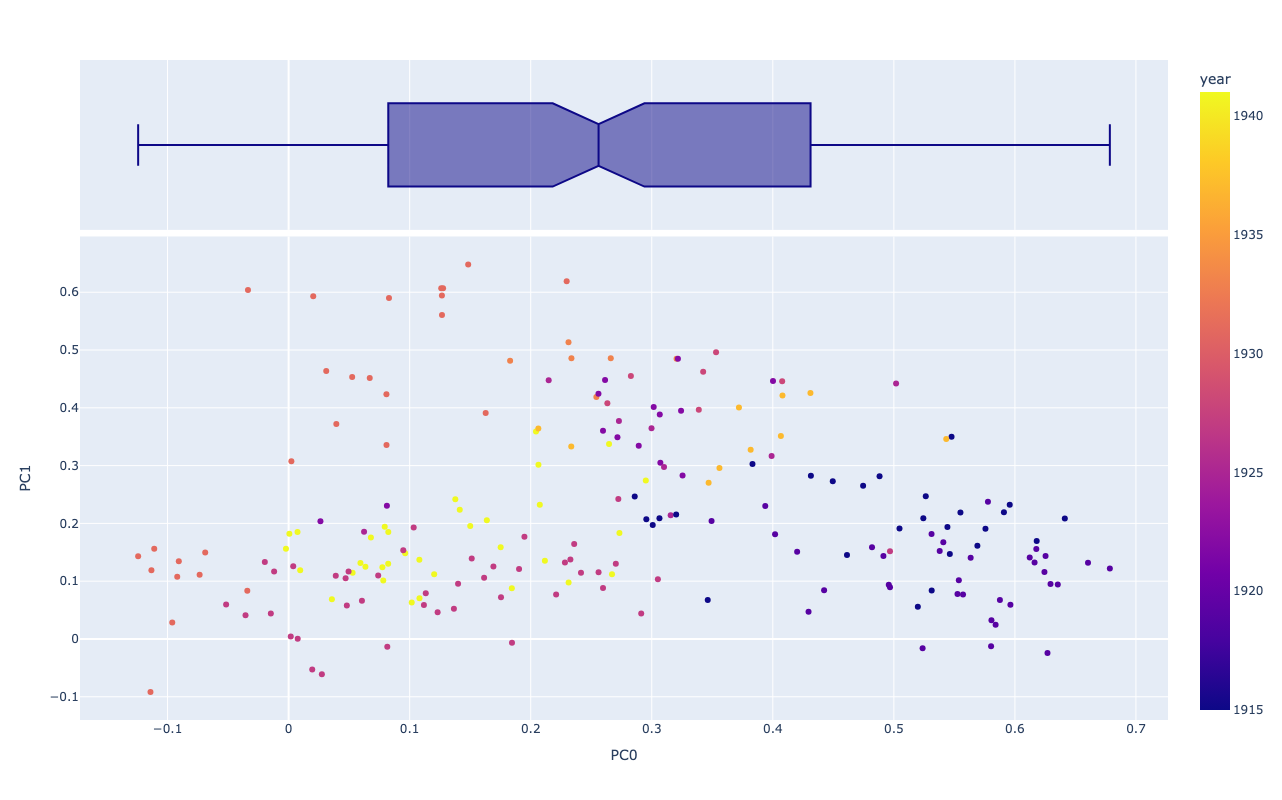

In [31]:
vis_pcs(DCM, 0, 1, label='year')

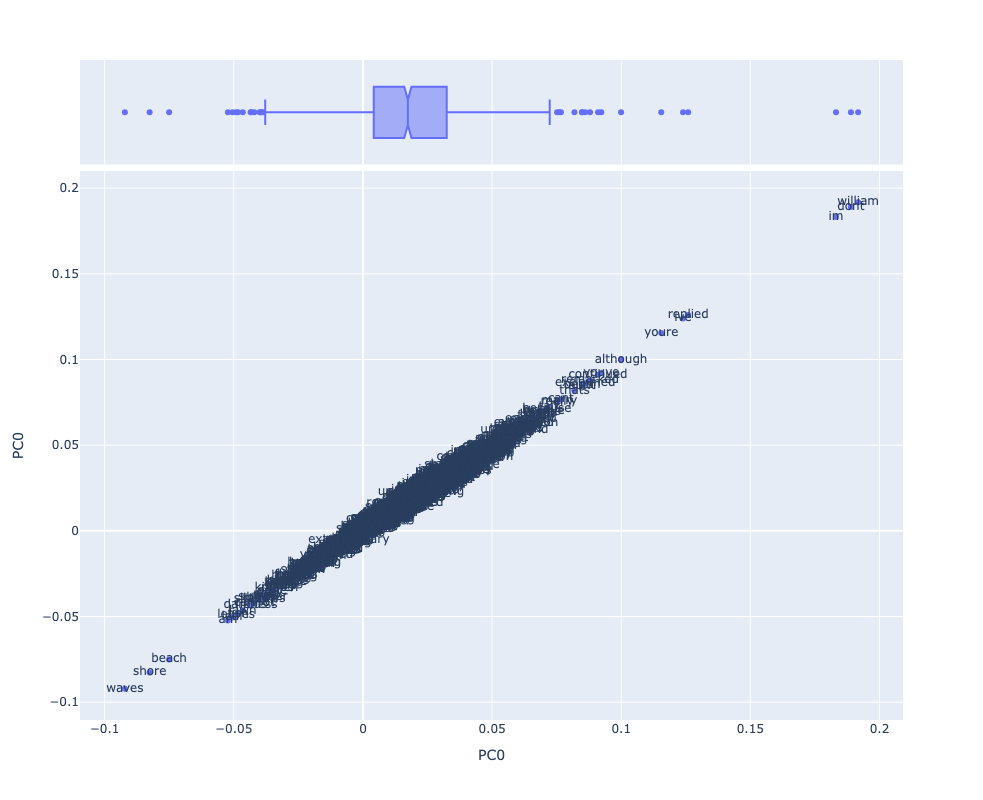

In [45]:
vis_loadings(0,0)

### PCA Visualization 2
→ Include a scatterplot of documents in the space created by the second two components.

→ Color the points based on a metadata feature associated with the documents.

→ Also include a scatterplot of the loadings for the same two components. (This does not need a feature mapped onto color.)

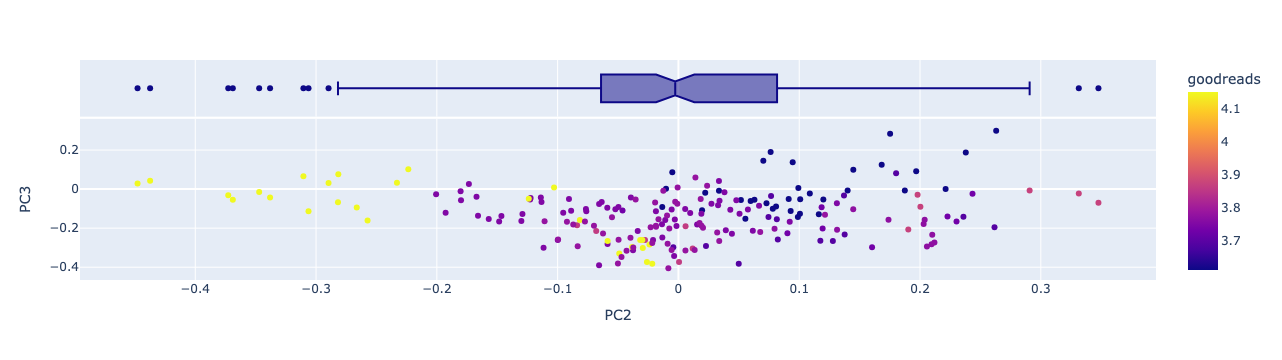

In [14]:
vis_pcs(DCM, 2, 3, label='goodreads')

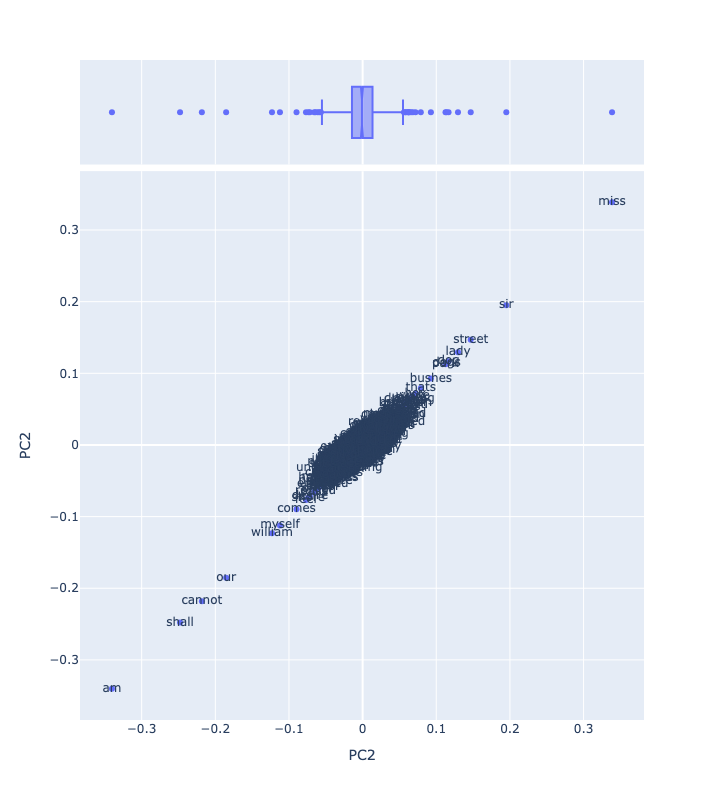

In [46]:
vis_loadings(2,2)

# Saving tables

In [16]:
COMPS.iloc[:,[0,-1]].to_csv("/Users/lucyshichman/Documents/MSDS/DS5001/final_project/woolf2vec/output/pca_comps.csv")
DCM.iloc[:,:10].to_csv("/Users/lucyshichman/Documents/MSDS/DS5001/final_project/woolf2vec/output/pca_dcm.csv")
LOADINGS.to_csv("/Users/lucyshichman/Documents/MSDS/DS5001/final_project/woolf2vec/output/pca_loadings.csv")